# Web Intelligence

## Random Forest

#### Prof. Claudio Lucchese

## Bias-Variance Decomposition

The error of a classifier/regressor can be decomposed in:
- **Bias$^2$**: The goodness of the algorithm for the specific problem
- **Variance**: The variance of predictions for the same $x$
- **Irreducible Error/Noise**: This cannot be removed

These three components of the error can be attacked with the following techniques:

- **Bagging**: **reduces variance** of a base classifier
- **Boosting** **reduces bias** of a base classifier
  

It is clear that it makes sense to apply **bagging** to a model with **low bias and high variance**, while one can use **boosting** to improve a model having **high bias and low variance**.


## Bagging looks a good starting point...

Between the above two options, we focus on bagging for a moment.

The reason is that boosting is prone to over-fitting as it focuses on misclassified instances, including noise and outliers. On the other hand, we have seen that a decision tree with several leaves has low bias and high variance, which makes it a good candidate for bagging. 

We thus try to answer the following question: **How can improve bagging performance for decision trees?**

To do so, let's recall one main property of bagging:
- bagging is effective when base models are **independent**.

We used **bootstrap samples** to train independent decision trees. Still, bootstrap dataset share several instances and are somewhat similar. So are models.

We need some additional strategy, in addition to bootstrap samples, to make sure resulting models are as much as possible independent. Roughly speaking, we need to make the different decision tree diverse from one another without hindering their performance. **How can we grow trees that are dissimilar one another?**


Bootstrap samples focus on the data provided to the tree construction algorithm. Probably there is not much we can do by working on data. Therefore, we might explore **how modify the tree construction algorithm** in order **to boost diversity of trees**.

## Random Forest

**Random Forest** is a modification of the standard tree growing algorithm that works as follows:
- **Bagging** is exploited to improve accuracy of single decision trees.
- **Trees are fully grown** until pure leaves
  - recall that bagging does not reduce bias, therefore we need accurate (low bias) trees.
- **Random input selection** is used during not splitting
  - each node is built on a small random subset of the feature set.
  
<div class="alert alert-info">
    
**Random Forest Algorithm**

1. **for** $i=1$ to $k$:
1. $\quad$ get a bootstrap sample $D_i$ from dataset $D$
1. $\quad$ train a full tree $M_i$ on $D_i$
1. $\quad\quad$ at each split use only $F\ll d$ random features
1. RF = $\bigcup\limits_{i=1}^k M_i$ 
1. **return** RF

</div>

As with bagging, the prediction of a random forest is provided by averaging the base models for regression and by majority voting for classification.

Let $d$ be the number of features in the input dataset $D$, usually a small random subset of size $F\ll d$ is used to select a split. Note that at each node $F$ features are selected at random again, and, therefore, a tree can potentially use all the available features. The random input selections forces the algorithm to use different features than a basic decision tree, thus boosting the diversity of trees in the ensemble, and potentially conter-balancing the greedy-ness of split selection. Usually $F=\sqrt{d}$, but also other options make sense, $F=\log_2(d)$.

#### Summary

What did we achieve with this new Random Forest algorithm?
- each tree has **little bias** (and large variance) because it is fully grown
- **bagging** several trees **reduces the variance** of resulting the aggregate model
- **trees are very diverse** and uncorrelated because of *random input selection*
- **learning is very efficient**:
  - trees can be trained **independently in parallel**
  - at each node only **a small subset of features is considered**

## Experimental Analysis of the Random Forest Algorithm

Below we apply Random Forest to a binary classification dataset.

See below for the sklearn implementation of Random Forest:
 - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

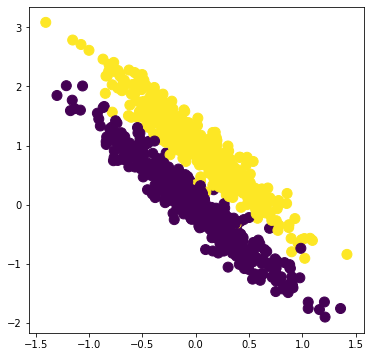

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# generate some random data
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=1000, centers=[[0,0],[1,1]], 
                  cluster_std=.3, random_state=2)
transformation = [[1, -1], [-1, 2]]
X = np.dot(X, transformation)

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X[:,0], X[:,1], c=y, s=100)

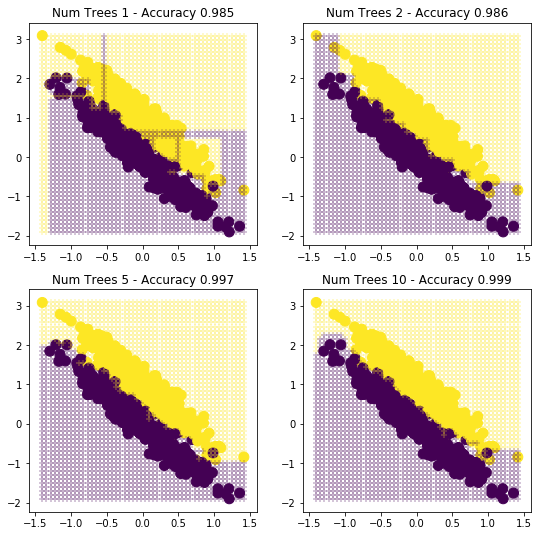

In [2]:
# Warning: we are evaluating on the training set!

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# compute the grid for decision surface
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
zz = [ [xx,yy] for xx in np.linspace(x_min, x_max, 50) 
               for yy in np.linspace(y_min, y_max, 50) ]
zz = np.array(zz)

# plot data and decition map
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, 
                        figsize=(9,9))

# Try changin the number of trees
n_trees = [1,2,5,10]
for ax, t in zip(axs.flatten(), n_trees):
    
    # train a decision tree classifier
    rf = RandomForestClassifier(n_estimators=t)
    rf.fit(X,y)
    acc = accuracy_score(y_true=y, y_pred=rf.predict(X))

    Z = rf.predict(zz)
    ax.scatter(X[:,0], X[:,1], c=y, s=100)
    ax.scatter(zz[:,0], zz[:,1], c=Z, marker='+', alpha=0.3)
    ax.set_title('Num Trees {} - Accuracy {}'.format(t,acc))

#### Remarks

We observe that the regularity of the decision surface improves when increasing the number of trees (together with the overall accuracy). This is due to the reduction of variance achieved by *ensembling* several decision trees.

Can we actually measure such variance reduction? By pretending this is a regression task, we compute below bias and variance by repeatedly learning a random forests on different data samples.


In [1]:
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier

N_TESTS = 20

stats = np.array([])

boosts = range(1,51)
for l in boosts:
    y_preds = np.array([])
    
    for i in range(N_TESTS):
        Xs, ys = resample(X,y, n_samples=int(0.67*len(y)) )

        # train a decision tree classifier
        rf = RandomForestClassifier(n_estimators=l)
        rf.fit(Xs,ys)
        
        y_pred = rf.predict(X)
        y_preds = np.column_stack( [y_preds, y_pred] ) if y_preds.size else y_pred

    dt_bias     = (y-np.mean(y_preds,axis=1))**2
    dt_variance = np.var(y_preds,axis=1)
    dt_error    = (y_preds - y.reshape(-1,1))**2

    
    run_stats = np.array([dt_error.mean(), dt_bias.mean(), dt_variance.mean()])
    
    stats = np.column_stack( [stats, run_stats]) if stats.size else run_stats
    
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(boosts,stats[0,:], 'o:', label='Error')
ax.plot(boosts,stats[1,:], 'o:', label='Bias$^2$')
ax.plot(boosts,stats[2,:], 'o:', label='Variance')
ax.set_xlabel('Number of Trees')
ax.grid()
ax.legend()

print (stats[:,-1])

NameError: name 'np' is not defined

#### Remarks

We observe that bias is not much impacted, while, as expected, **variance is greatly reduced** (by a factor of 3). Up to some random fluctuation, this is the best result we achieved so far.

We see that variance is still the major cause of error, therefore, one should try to further reduce variance to get better performance. Some options are *a)* increasing the number of trees and *b)* reducing the number of nodes in the base tree.

**Warning!** How many features did we use for the *random input selection* in the base tree?

We used $\sqrt{2}$ features! We should not consider this as a true random forest as we do not have a sufficiently large features set to implement *random input selection*. Rather, we are visualizing the effect of using fully grown trees.

## Let's get a better dataset

In [4]:
## Let's get a better dataset

from sklearn.datasets import load_boston
data = load_boston()

print (data['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [5]:
X = data.data
y = data.target

print (X.shape)
print (y.shape)
print (data.feature_names)

(506, 13)
(506,)
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


[8.06408745 5.29654114 2.7675463 ]


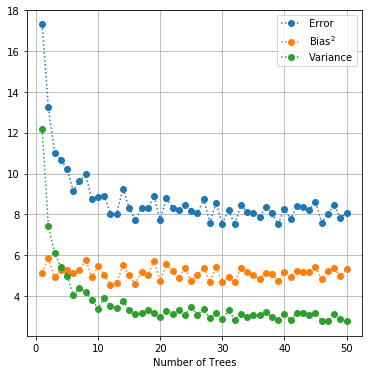

In [6]:
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

N_TESTS = 20

stats = np.array([])

boosts = range(1,51)
for l in boosts:
    y_preds = np.array([])
    
    for i in range(N_TESTS):
        Xs, ys = resample(X,y, n_samples=int(0.67*len(y)) )

        # train a decision tree classifier
        rf = RandomForestRegressor(n_estimators=l)
        rf.fit(Xs,ys)
        
        y_pred = rf.predict(X)
        y_preds = np.column_stack( [y_preds, y_pred] ) if y_preds.size else y_pred

    dt_bias     = (y-np.mean(y_preds,axis=1))**2
    dt_variance = np.var(y_preds,axis=1)
    dt_error    = (y_preds - y.reshape(-1,1))**2.0
        
    run_stats = np.array([dt_error.mean(), dt_bias.mean(), dt_variance.mean()])
    
    stats = np.column_stack( [stats, run_stats]) if stats.size else run_stats
    
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(boosts,stats[0,:], 'o:', label='Error')
ax.plot(boosts,stats[1,:], 'o:', label='Bias$^2$')
ax.plot(boosts,stats[2,:], 'o:', label='Variance')
ax.set_xlabel('Number of Trees')
ax.grid()
ax.legend()

print (stats[:,-1])

#### Remarks

Note how variance is reduced (nearly by a factor of 4). In this case, the variance falls below the bias, meaning that there isn't much we can get by adding more trees. 

How can we reduce bias?

## Ensemble methods wrap-up

Now we are ready to compare the three different ensemble methods we have seen so far.

In [7]:
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

# try changing params
# try comparing models with the same "power"
#           i.e., number of nodes.

dt = DecisionTreeRegressor(max_leaf_nodes=10)

adaboost = AdaBoostRegressor(DecisionTreeRegressor(max_leaf_nodes=10), 
                             n_estimators=100)

bagging = BaggingRegressor(DecisionTreeRegressor(max_leaf_nodes=100),
                          n_estimators=10)

rf = RandomForestRegressor(n_estimators=10)


models = [ ('Decision Tree', dt), ('AdaBoost', adaboost),
           ('Bagging', bagging), ('RandomForest', rf)]

for name, regressor in models:

    scores = cross_val_score(regressor, X, y, cv=5, scoring='neg_mean_squared_error')
    print ("Algo:", name, "\tMSE:", -scores.mean())



Algo: Decision Tree 	MSE: 39.99803394258739
Algo: AdaBoost 	MSE: 23.0401987976933
Algo: Bagging 	MSE: 21.470708148245897
Algo: RandomForest 	MSE: 21.034861896719082


Among Bagging, Boosting and Random Forest, there is not a clear winner. It largely depends on the data. The bias-variance analysis help to understand the weaknesses of a given model. Note that mode ensemble methods can be applied to any base model, e.g., bagging over kNN classifier. Decision trees are a common choice for their efficiency and their flexibility.


Some additional results:

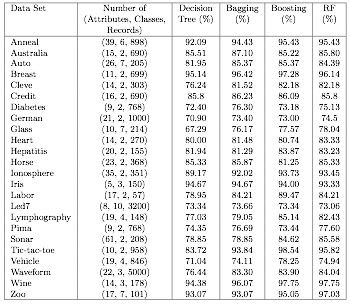

## Random Forest as a Similarity Estimator

<div class='alert alert-danger'>

**Note:** Not everything below is in the book.

</div>


Ultimately, **a model groups together similar instances** and provides the same prediction for them. A decision trees uses node predicates to identify a subset of instances for which the same prediction is provided. To this extent, **this similarity grouping is based on the target label** rather than features. In a way, this overcomes the problem of correctly weighing features to compute similarity: which features are relevant and how to determine whether two instances are similar is implicitly determined by the training algorithm.
  
  
### How to exploit a Random Forest to compute the similarity among different instances?

We can build a similarity measure on the basis of the following assumption:
- two instances are similar if they traverse the random forest along the same paths

Which means that two instances are similar if they fall in the same leaves. We thus measure the similarity between two instances as **the fraction of common leaves reached while traversing the forest**.

In principle, this could be applied to any forest of decision trees, including bagging and boosting. Random Forest is preferable for the following reasons:
  - RF is better than Boosting as RF give equal weight to the trees
  - RF is better than Bagging as its trees are more diverse
  
Below, we use a random forest to estimate the similarity among two instances and we use the resulting similarity measure to feed the DB-Scan clustering algorithm.

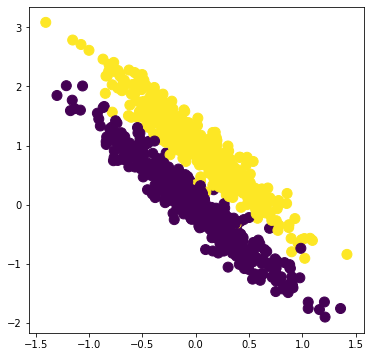

In [8]:
# generate some random data
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=1000, centers=[[0,0],[1,1]], 
                  cluster_std=.3, random_state=2)
transformation = [[1, -1], [-1, 2]]
X = np.dot(X, transformation)

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X[:,0], X[:,1], c=y, s=100)

Accuracy: 1.0


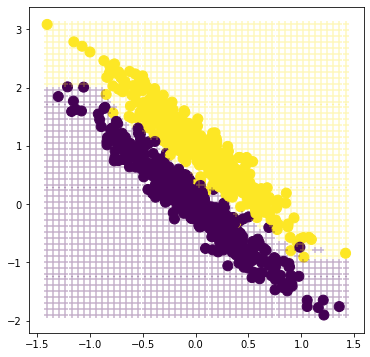

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# train a decision tree classifier
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X,y)
print ("Accuracy:", accuracy_score(y_true=y, y_pred=rf.predict(X)) )

# compute the decition map
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
zz = [ [xx,yy] for xx in np.linspace(x_min, x_max, 50) 
               for yy in np.linspace(y_min, y_max, 50) ]
zz = np.array(zz)
Z = rf.predict(zz)

# plot data and decition map
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X[:,0], X[:,1], c=y, s=100)
ax.scatter(zz[:,0], zz[:,1], c=Z, marker='+', alpha=0.3)

The function `apply` returns ids of the reached leaves in the form of a matrix of size $m \times n$ where $m$ is the number of instances and $n$ is the number of trees.

In [10]:
leaves = rf.apply(X)

In [11]:
leaves.shape

(1000, 50)

In [12]:
leaves[0], y[0]

(array([19, 35, 59, 16, 11, 64, 69, 16, 33, 30, 68, 76, 49, 16, 64, 26, 48,
        76, 39, 20, 55, 52, 51, 94, 54, 28, 43, 24, 51, 41, 20, 62, 45, 29,
        26, 45, 57, 67, 27, 59, 55, 45, 82, 19, 22, 33, 16, 45, 37, 32],
       dtype=int64), 1)

In [13]:
leaves[1], y[1]

(array([76, 35, 59, 35, 36, 24, 46, 64, 32, 68, 33, 74, 49, 32, 71, 41, 58,
        76, 36, 33, 55, 42, 43, 94, 54, 90, 35, 24, 39, 41, 39, 59, 37, 34,
        26, 21, 57, 61, 20, 66, 55, 45, 81, 40, 45, 29, 27, 45, 37, 49],
       dtype=int64), 1)

Class is the same, leaves are not, but some are shared ...

#### DBScan on the original data

Try tuning DB-Scan parameters. It's not trivial to come up with a good result. Informally, we will used this hardness and instability to evaluate the similarity measure produce by a random forest.

Text(0.5, 1.0, 'DBScan')

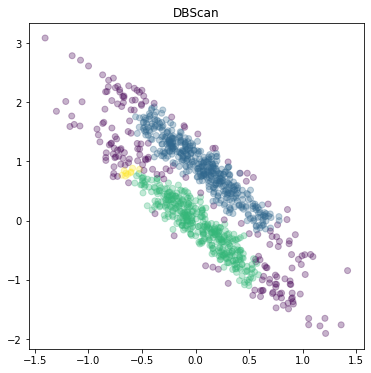

In [14]:
from sklearn.cluster import DBSCAN

# try changing params
dbscan = DBSCAN(eps=0.1, min_samples=10)
dbscan.fit(X)

# plot output of k-means
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X[:,0], X[:,1], c=dbscan.labels_, alpha=0.3)
ax.set_title("DBScan")


#### DBScan exploiting RandomForest Similarity

We compute all pair-wise distances as 1 minus the fraction of common leaves.

In [15]:
from sklearn.metrics import pairwise_distances

# Note: we need a distance
pair_wise_dist = pairwise_distances( X=leaves, 
                                     metric= lambda oi, oj: 
                                             1.0-np.mean(oi==oj))

pair_wise_dist.shape

(1000, 1000)

You will notice that the clustering result is probably better. Note that "undecided" instances are marked as outliers. Also, by changing the parameters the clustering keeps being reasonably good suggesting a better quality of the similarity measure.

Text(0.5, 1.0, 'DBScan on RF Similarity')

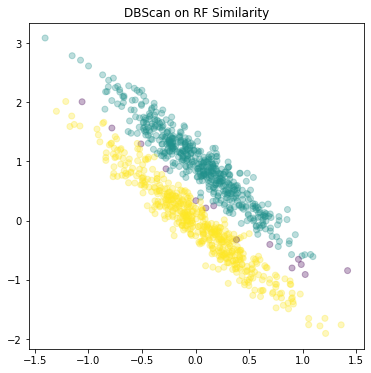

In [16]:
# try changing params
dbscan = DBSCAN(eps=.5, min_samples=5, metric="precomputed")
dbscan.fit(pair_wise_dist)

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X[:,0], X[:,1], c=dbscan.labels_, alpha=0.3)
ax.set_title("DBScan on RF Similarity")


Below we visualize the Euclidean distance and the random forest distance to see its "shape" in the given 2D space.

####  Euclidean Distance

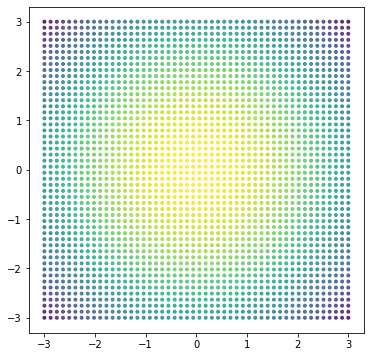

In [17]:
origin = np.array([0.0,0.0])

# compute the decition map
x_min, x_max = -3,3 #X[:, 0].min(), X[:, 0].max()
y_min, y_max = -3,3 #X[:, 1].min(), X[:, 1].max()
zz = [ [xx,yy] for xx in np.linspace(x_min, x_max, 50) 
               for yy in np.linspace(y_min, y_max, 50) ]
zz = np.array(zz)
Z = np.sum( (zz-origin)**2.0, axis=1)
Z = Z.max()-Z

# plot data and decition map
fig, ax = plt.subplots(figsize=(6,6))
#ax.scatter(X[:,0], X[:,1], c=y, s=100, alpha=0.2)
ax.scatter(zz[:,0], zz[:,1], c=Z, marker='.', alpha=.8)

####  Random Forest Distance

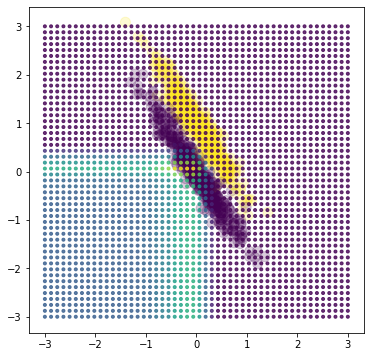

In [18]:
# train a decision tree classifier
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X,y)

# change origin
origin = rf.apply( [ np.array([0.0,0.0]) ] )

# compute the decition map
x_min, x_max = -3,3 #X[:, 0].min(), X[:, 0].max()
y_min, y_max = -3,3 #X[:, 1].min(), X[:, 1].max()
zz = [ [xx,yy] for xx in np.linspace(x_min, x_max, 50) 
               for yy in np.linspace(y_min, y_max, 50) ]
zz = np.array(zz)
Z = rf.apply(zz)

Z = (Z==origin).mean(axis=1)

# plot data and decition map
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X[:,0], X[:,1], c=y, s=100, alpha=0.2)
ax.scatter(zz[:,0], zz[:,1], c=Z, marker='.', alpha=.8)

### More on outliers

Following a similar line of reasoning, we can use a Random Forest to identify outliers in our dataset before/without running a clustering algorithm.

We can informally define as outliers those instances that are dissimilar from the other points in the dataset. We thus define an **outlier score** of an instance as the inverse of the cumulative squared similarity with all the other points in the datset. More formally, for an instance $o_i \in D$ we have:
$$
out(o_i) = \frac{1}{\sum\limits_{o_j \in D} RF\_sim(o_i, o_j)^2}
$$

where $RF\_sim$ is the random forest similarity (not distance!).

Below we visualize the output of DB-Scan (using random forest distance) where the outlier score of each instance is rendered through the size of the marker. Note how the outlier score increases as we move far away from cluster centers or when we reach the border between the two clusters.

In [ ]:
# Note: we need a similarity
pair_wise_sim = pairwise_distances( X=leaves, 
                                     metric= lambda oi, oj: 
                                             np.mean(oi==oj))

out = (pair_wise_sim**2).sum(axis=0)**-1

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X[:,0], X[:,1], c=dbscan.labels_, s=out*1000, alpha=0.3)
ax.set_title("Random Forest Outlier score")

## Random Forest for missing value imputation


The Random Forest similarity score can also be exploited for **missing value imputation**, that is to replace a missing value with a reasonable guess. The rationale is as follows: fill missing value by copying that of similar instances.

Let's consider and instance $o_i \in D$  where feature $f$ is missing. Imputation happens through the following iterative procedure.

<div class="alert alert-info">

**Missing Value Imputation**
    
1. Replace missing value with the average value of all other instances $j$ where $f$ is not missing, weighting by the RF similarity score of $(o_i,o_j)$
$$
o_i'[f] = \frac{ \sum\limits_{\substack{o_j \in D \\ o_j[f]\neq NaN}} o_j[f]\cdot RF\_sim(o_i, o_j)}{\sum\limits_{\substack{o_j \in D \\ o_j[f]\neq NaN}}  RF\_sim(o_i, o_j)}
$$
1. Train a new Random Forest on the modified data, and compute new similarity scores
  - The new RF might be completely different
1. Repeat until no further improvements.
</div>
  
#### Exercise:
Take a full dataset, simulate missing values by "erasing" some, measure the accuracy of the value estimated by Random Forest.

## Feature Importance and Feature Selection

- Feature importance can computed by accumulating the loss reduction achieved by the corresponding nodes across the forest.

- Scikit-learn provides a normalized (sums to 1) feature importance score

- Let's evaluate the goodness of the model when using only a subset of the features available.

In [19]:
X = data.data
y = data.target

print (X.shape)
print (y.shape)
print (data.feature_names)

(506, 13)
(506,)
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [20]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [21]:
rf.feature_importances_

array([0.03586084, 0.00100042, 0.00551379, 0.0011911 , 0.02336458,
       0.44581882, 0.01238281, 0.06741689, 0.00425653, 0.01442858,
       0.01694059, 0.01287211, 0.35895294])

Text(0.5, 1.0, 'Feature Importances')

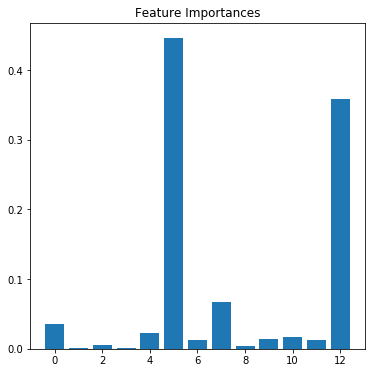

In [22]:
fig, ax = plt.subplots(figsize=(6,6))
ax.bar(range(0,X.shape[1]), rf.feature_importances_)
ax.set_title("Feature Importances")

In [23]:
best_features = np.argsort(rf.feature_importances_)[::-1]

rmse = []

for f in range(1,len(best_features)+1):
    rf_small = RandomForestRegressor(n_estimators=100)
    scores = cross_val_score(rf_small, 
                             X[:,best_features[:f]], y, 
                             cv=5, scoring='neg_mean_squared_error')
    rmse += [-scores.mean()]

Full score: 21.75566613440107
Best score: 20.67139430326149


Text(0.5, 0, 'Number of Best features used')

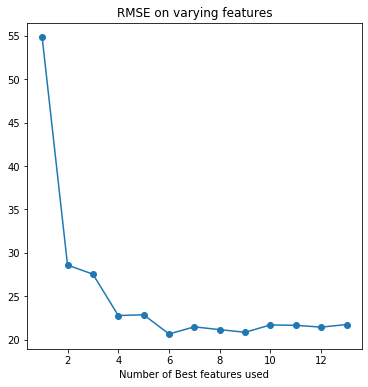

In [24]:
print ("Full score:", rmse[-1])
print ("Best score:", min(rmse))

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(range(1,len(best_features)+1), rmse, 'o-', label="RMSE")
ax.set_title("RMSE on varying features")
ax.set_xlabel("Number of Best features used")

## Recursive Elimination

- The ranking might be affected by feature interactions (e.g., dependencies, or correlations)

- We can apply the above ranking and selection recursively:
  - Build a Random Forest
  - Discard a few low scored features
  - Repeat
  
See: 
 - https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn-feature-selection-rfe

In [25]:
from sklearn.feature_selection import RFE

rf_small = RandomForestRegressor(n_estimators=100)
selector = RFE(rf_small, 
                 step=1, # features removed at each step
                 n_features_to_select=1 # selected features
                )
selector.fit(X,y)

RFE(estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                    max_depth=None, max_features='auto',
                                    max_leaf_nodes=None,
                                    min_impurity_decrease=0.0,
                                    min_impurity_split=None, min_samples_leaf=1,
                                    min_samples_split=2,
                                    min_weight_fraction_leaf=0.0,
                                    n_estimators=100, n_jobs=None,
                                    oob_score=False, random_state=None,
                                    verbose=0, warm_start=False),
    n_features_to_select=1, step=1, verbose=0)

In [26]:
# Features ranking
np.argsort(selector.ranking_)

array([12,  5,  7,  0,  4, 10,  6,  9, 11,  2,  8,  1,  3], dtype=int64)

In [27]:
best_features

array([ 5, 12,  7,  0,  4, 10,  9, 11,  6,  2,  8,  3,  1], dtype=int64)

### Use cross-validation to select the best subset of features

Differently from before, it returns the best number of features.

See:
 - https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV

In [28]:
from sklearn.feature_selection import RFECV

rf_small = RandomForestRegressor(n_estimators=100)
selector = RFECV(rf_small, 
                 step=1, # features removed at each step
                 cv=5,   # cross validation folds
                 scoring='neg_mean_squared_error',
                 min_features_to_select=1 # selected features
                )
selector.fit(X,y)

RFECV(cv=5,
      estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                      max_depth=None, max_features='auto',
                                      max_leaf_nodes=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=100, n_jobs=None,
                                      oob_score=False, random_state=None,
                                      verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

In [29]:
# Best selected features
selector.support_

array([ True, False,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True])

## References

- **Data Mining Concepts and Techniques Third Edition**. Jiawei Han, Micheline Kamber Jian Pei.  Morgan Kaufmann/Elsevier. Third Edition. 2012.
  - Section 8.6.4 Random Forests

- Additional notes on Random Forests
  - http://www.math.mcgill.ca/yyang/resources/doc/randomforest.pdf